In [50]:
import os
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [51]:
rng = jax.random.PRNGKey(1)

## Part 1: State Space Models

In [52]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

In [53]:
A, B, C = random_SSM(rng, 3)
print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

A shape: (3, 3)
B shape: (3, 1)
C shape: (1, 3)


### Discrete-time SSM: The Recurrent Representation

In [54]:
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

In [55]:
Ab, Bb, C = discretize(A, B, C, 0.1)
print("Ab shape:", Ab.shape)
print("Bb shape:", Bb.shape)
print("C shape:",  C.shape)

Ab shape: (3, 3)
Bb shape: (3, 1)
C shape: (1, 3)


In [56]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

In [57]:
u = np.ones((10, 1))
x0 = np.zeros((3,))
x, y = scan_SSM(Ab, Bb, C, u, x0)
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (3,)
y shape: (10, 1)


In [58]:
def run_SSM(A, B, C, u):
    """
    Run a State Space Model (SSM).
    
    Parameters:
        A: Continuous-time state matrix (NxN)
        B: Continuous-time input matrix (Nx1)
        C: Output matrix (1xN)
        u: Input signal (L-dimensional vector)
    
    Returns:
        The output of the state space model after running.
    """
    L = u.shape[0]
    N = A.shape[0]
    
    # Discretize the continuous-time state space model (A, B, C)
    # step is the discretization step size, set to 1.0 / L here
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)
    
    # Run the recursive computation of the state space model
    # Initial state is set to zero vector np.zeros((N,))
    # scan_SSM returns two values, we only take the second one which is the model output
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

In [59]:
u = np.ones((10,))
y = run_SSM(A, B, C, u)
print("y shape:", y.shape)

y shape: (10, 1)


### Tangent: A Mechanics Example

In [60]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

In [61]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

In [62]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    os.makedirs('images', exist_ok=True)
    anim.save("images/line.gif", dpi=150, writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


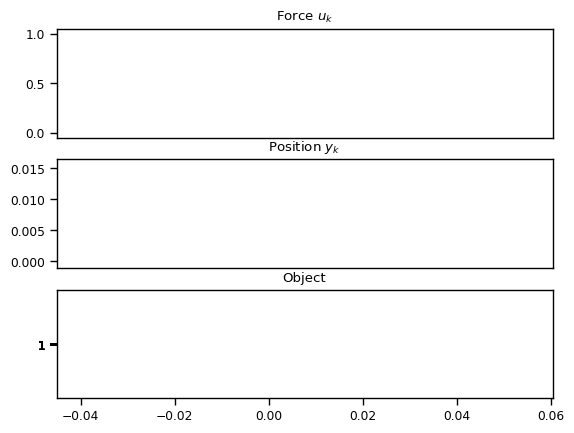

In [63]:
example_ssm()

### Training SSMs: The Convolutional Representation

In [64]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

In [65]:
K = K_conv(Ab, Bb, C, L=10)
print("K shape:", K.shape)

K shape: (10,)


In [66]:
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

In [67]:
u1 = causal_convolution(u, K, nofft=False)
print("u1 shape:", u1.shape)


u1 shape: (10,)


In [68]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

In [69]:
test_cnn_is_rnn(N=4, L=16, step=1.0 / 16)

### An SSM Neural Network

In [70]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init

In [76]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [77]:
# Initialize SSM layer
N = 4
L = 10
ssm = SSMLayer(N=N, l_max=L)

# Initialize parameters with a random key
key = jax.random.PRNGKey(0)
params = ssm.init(key, u)

print("\nInitialized parameters:")
for key, value in params.items():
    print(f"{key}:")
    for param_name, param_value in value.items():
        print(f"  {param_name}: shape {param_value.shape}")


Initialized parameters:
params:
  A: shape (4, 4)
  B: shape (4, 1)
  C: shape (1, 4)
  D: shape (1,)
  log_step: shape (1,)
cache:
  cache_x_k: shape (4,)


In [78]:
# Forward pass in CNN mode (decode=False)
output_cnn = ssm.apply(params, u)
print("\nCNN mode output:\n", output_cnn)
print("Output shape:", output_cnn.shape)

# Forward pass in RNN mode (decode=True)
ssm_rnn = SSMLayer(N=N, l_max=L, decode=True)
output_rnn = ssm_rnn.apply(params, u)
print("\nRNN mode output:\n", output_rnn)
print("Output shape:", output_rnn.shape)


CNN mode output:
 [0.991806   0.98362285 0.97545004 0.9672872  0.9591337  0.9509891
 0.9428531  0.93472517 0.92660487 0.9184918 ]
Output shape: (10,)

RNN mode output:
 [0.991806   0.98362285 0.97545004 0.9672872  0.9591337  0.9509891
 0.9428531  0.9347251  0.9266048  0.9184917 ]
Output shape: (10,)


In [79]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)

In [80]:
class SequenceBlock(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Hyperparameters of inner layer
    dropout: float
    d_model: int
    prenorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer_cls(**self.layer, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.gelu(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x

In [90]:
class Embedding(nn.Embed):
    num_embeddings: int     # Vocabulary size
    features: int           # Embedding dimension

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)

class StackedModel(nn.Module):
    layer_cls: nn.Module    # Layer class to use (e.g., SSMLayer)
    layer: dict             # Layer configuration parameters
    d_output: int           # Output dimension (e.g., vocab size)
    d_model: int            # Model hidden dimension
    n_layers: int           # Number of layers to stack
    prenorm: bool = True    # Whether to apply normalization before layer
    dropout: float = 0.0    # Dropout rate
    embedding: bool = False # Whether to use embedding or dense layer for encoding
    classification: bool = False
    training: bool = True
    decode: bool = False    # Decoding mode flag (for autoregressive generation)

    def setup(self):
        # Input encoder
        if self.embedding:
            # For discrete inputs (e.g., tokens)
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            # For continuous inputs
            self.encoder = nn.Dense(self.d_model)
        
        # Output decoder
        self.decoder = nn.Dense(self.d_output)
        
        # Stack of sequence processing layers
        self.layers = [
            SequenceBlock(
                layer_cls=self.layer_cls,
                layer=self.layer,
                prenorm=self.prenorm,
                d_model=self.d_model,
                dropout=self.dropout,
                training=self.training,
                decode=self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        if not self.classification:
            if not self.embedding:
                # Normalize pixel values for image data
                x = x / 255.0
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
        
        # Encode input
        x = self.encoder(x)
        
        # Process through layers
        for layer in self.layers:
            x = layer(x)
        
        if self.classification:
            # Global average pooling for classification
            x = np.mean(x, axis=0)
        
        # Decode to output dimension
        x = self.decoder(x)

        # Apply log softmax for probability distribution
        return nn.log_softmax(x, axis=-1)

In [92]:
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True},
)

In [ ]:
def test_batch_stacked_model():
    B = 2 # Batch size
    T = 3 # Sequence length
    C = 2 # Input dimension
    O = 3 # Output dimension
    x = np.ones((B, T, C))
    
    print("=== Input Tensor ===")
    print("Shape:", x.shape)

    # Initialize BatchStackedModel
    N = 4                              # State dimension
    
    model = BatchStackedModel(
        layer_cls=SSMLayer,
        layer={"N": N, "l_max": T},    # SSM config
        d_output=O,                    # Output dimension
        d_model=N,                     # Hidden dimension
        n_layers=2,                    # Number of layers
        embedding=False                # Use dense layer
    )
    
    # Initialize parameters
    key = jax.random.PRNGKey(0)
    params = model.init(key, x)
    
    # Forward pass
    output = model.apply(params, x)
    
    print("\n=== Output Tensor ===")
    print("Shape:", output.shape)

# Run test
test_batch_stacked_model()

=== Input Tensor ===
Shape: (2, 3, 2)

=== Output Tensor ===
Shape: (2, 3, 3)


: 